## Data Pre-Processing

In [58]:
import pandas as pd
import unicodedata

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\recipes_w_search_terms.csv").head(1500)

# Select only the desired columns
df = df[['id', 'steps', 'ingredients']]

# # Check for rows with missing values
# # If all rows are filled, this should be zero
# missing_rows = df.isnull().sum(axis=1).sum()
# if missing_rows > 0:
#     print(f"There are {missing_rows} missing values. Please fill or clean these rows.")
# else:
#     print("All rows are filled!")


# Function to split each sentence by period while maintaining the original list structure
def split_instructions(instructions):
    if pd.isnull(instructions):
        return instructions
    # Convert the string representation of the list into an actual list
    instruction_list = eval(instructions) if isinstance(instructions, str) else instructions
    # Split each step by periods and flatten the resulting list
    split_items = []
    for step in instruction_list:
        split_items.extend([item.strip() for item in step.split('.') if item.strip()])
    return split_items

# Function to remove accents
def remove_accents(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    return ''.join(c for c in normalized_text if not unicodedata.combining(c))

# Apply functions to the columns
df['steps'] = df['steps'].apply(split_instructions).apply(lambda x: [remove_accents(item.lower()) for item in x] if isinstance(x, list) else x)
df['ingredients'] = df['ingredients'].apply(lambda x: [remove_accents(item.lower()) for item in x] if isinstance(x, list) else x)


df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\recipe_instructions_dataset.csv")

## FLAN T-5 Extraction

In [11]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import ast

# Load the dataset (recipe instructions dataset)
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\recipe_instructions_dataset.csv")

# Ensure ingredients column is a list if it is a string representation of a list
if isinstance(df['ingredients'][0], str):
    df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

# Convert the steps column to actual list from string representation
df['steps'] = df['steps'].apply(ast.literal_eval)

# Load the model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Function to extract ingredients from a single instruction using LLM
def llm_ingredient_extraction(instruction):
    prompt = f"Extract the ingredient(s) mentioned in the following recipe instruction. Do not include quantities, units, or any additional descriptions, just the core name of the ingredient(s). Be precise and concise. For the instruction: '{instruction}', the ingredient(s) are:"
    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Generate prediction for the instruction
    outputs = model.generate(**inputs)
    
    # Decode the output for the instruction
    extracted_ingredient = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return extracted_ingredient

# Function to process recipe steps and extract ingredients
def process_recipe_steps(row):
    instructions = row['steps']  # List of recipe instructions (steps)
    ingredients_in_recipe = row['ingredients']  # List of ingredients
    
    extracted_ingredients = []
    
    # Process each instruction individually
    for instruction in instructions:
        # Extract ingredient from the instruction
        extracted_ingredient = llm_ingredient_extraction(instruction)
        
        # Add the extracted ingredient to the list
        extracted_ingredients.append(extracted_ingredient)
    
    return {
        "id": row['id'],
        "steps": row['steps'],
        "extracted_ingredients": extracted_ingredients,
        "ground_truth": ingredients_in_recipe
    }

# Apply the function to each row to extract ingredients from the instructions
df['extracted_results'] = df.apply(process_recipe_steps, axis=1)

# Convert the results into a new DataFrame
detailed_df = pd.DataFrame(df['extracted_results'].tolist())

# Save the detailed results to a CSV file
detailed_df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\extracted_ingredients_from_instructions.csv", index=False)

# Print a preview of the results
print(detailed_df.head())


C:\Users\teore\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\teore\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


       id                                              steps  \
0   96313  [i a sauce pan, bring water to a boil; slowly ...   
1  232037  [in a food processor, pulse the onion, red pep...   
2   41090  [in a large bowl, combine beans, tomato, onion...   
3   60656  [put all ingredients in the crock pot and cook...   
4  232047  [preheat oven to 350°f, cut beef into 1 inch c...   

                               extracted_ingredients  \
0                   [grits, garlic, olive oil, sage]   
1  [onion, red pepper, garlic, shrimp, oil, shrim...   
2                   [tomato, onion, celery, vinegar]   
3                                        [crock pot]   
4  [butter, beef, flour, salt, allspice, cinnamon...   

                                        ground_truth  
0  [water, grits, salt, cheddar cheese, garlic, o...  
1  [onion, red bell pepper, garlic cloves, large ...  
2  [white beans, canned black beans, tomatoes, on...  
3  [zucchini, yellow squash, diced tomatoes, onio...  
4  

## Strict Accuracy

In [59]:
import pandas as pd
import os
from nltk.stem import WordNetLemmatizer

# # Rename files for easier understanding (DO IT ONCE!)
# old_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\extracted_ingredients_from_instructions.csv"
# new_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\extracted_from_instructions_food.com.csv"
# os.rename(old_file_path, new_file_path)


# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\extracted_from_instructions_food.com.csv")

lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Function to lemmatize each item in a list
def lemmatize_from_list(ingredient_list):
    if isinstance(ingredient_list, list):  # Ensure it's a list before processing
        return [lemmatize_words(item) for item in ingredient_list]
    return ingredient_list  # Return the input if it's not a list

# Ensure ground truth is a list
df['ground_truth'] = df['ground_truth'].str.lower().apply(eval).apply(lemmatize_from_list)
df['extracted_ingredients'] = df['extracted_ingredients'].str.lower().apply(eval).apply(lemmatize_from_list)


# Function to split elements followed by a comma and add them to the list (this happened during extraction)
def split_ingredients(ingredients):
    new_ingredients = []
    for ingredient in ingredients:
        if (',' in ingredient):
            split_items = [item.strip() for item in ingredient.split(',')]
            new_ingredients.extend(split_items)
        if (';' in ingredient):
            split_items = [item.strip() for item in ingredient.split(';')]
            new_ingredients.extend(split_items)
        if (' and ' in ingredient):
            split_items = [item.strip() for item in ingredient.split(' and ')]
            new_ingredients.extend(split_items)
        else:
            new_ingredients.append(ingredient)
    return new_ingredients


# Function to remove duplicates and empty strings from a list
def remove_duplicates_and_empty(ingredients):
    return list(set(filter(None, ingredients)))

# Apply functions to each row in DataFrame
df['extracted_ingredients'] = df['extracted_ingredients'].apply(split_ingredients).apply(remove_duplicates_and_empty)
df['ground_truth'] = df['ground_truth'].apply(split_ingredients).apply(remove_duplicates_and_empty)


def check_strict_ingredients_in_ground_truth(row):
    """
    Strictly check if each ingredient in the extracted list matches exactly with an ingredient in the ground truth.
    """
    counter = 0
    unique_extracted_ingredients = set(row['extracted_ingredients'])  # Remove duplicates
    ground_truth_matched = set()  # Track matched ground truth ingredients
    matches = []

    for ingredient in unique_extracted_ingredients:
        if ingredient in row['ground_truth'] and ingredient not in ground_truth_matched:
            counter += 1
            ground_truth_matched.add(ingredient)  # Mark this ground truth as matched
            matches.append((ingredient, ingredient))

    # Calculate percentage of correct matches
    percentage = (counter / len(row['ground_truth'])) * 100 if len(row['ground_truth']) > 0 else 0
    return percentage, matches

#Sum the matches accross all rows and divide it by the total ingredients in the ground truth.
def calculate_overall_match_percentage(df, match_column, ground_truth_column):
    """
    Calculate the overall match percentage across all rows
    
    Args:
        df (pd.DataFrame): The DataFrame
        match_column (str): Column with match tuples
        ground_truth_column (str): Column with GT ingredient lists

    Returns:
        float: Ingredient match percentage.
    """
    total_matches = 0
    total_ground_truth_ingredients = 0

    for _, row in df.iterrows():
        # Count matches 
        total_matches += len(row[match_column])
        
        # Count the number of GT ingredients
        total_ground_truth_ingredients += len(row[ground_truth_column])

    # Calculate Ingredient match percentage
    overall_percentage = (total_matches / total_ground_truth_ingredients) * 100 if total_ground_truth_ingredients > 0 else 0
    return overall_percentage

# Apply the function to each row in the DataFrame and extract matches
results = df.apply(check_strict_ingredients_in_ground_truth, axis=1, result_type='expand')
df['matched_ingredients_percentage'] = results[0]
df['matches'] = results[1]

# Calculate recipe match percentage (including 0% recipes)
recipe_percentage_incl_zeros = df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage (Including 0% Recipes): {recipe_percentage_incl_zeros:.2f}%")

# Filter out rows with 0% matches
non_zero_df = df[df['matched_ingredients_percentage'] > 0]

# Calculate recipe match percentage (excluding 0% recipes)
recipe_percentage_excl_zeros = non_zero_df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage (Excluding 0% Recipes): {recipe_percentage_excl_zeros:.2f}%")

#Overall Percentage
overall_percentage = calculate_overall_match_percentage(df, match_column='matches', ground_truth_column='ground_truth')
print(f"Overall Percentage: {overall_percentage:.2f}%")

# # Save the DataFrame with the new column to a CSV file
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\instructions_extracted_food.com_strict.csv", index=False)

Recipe Percentage (Including 0% Recipes): 31.18%
Recipe Percentage (Excluding 0% Recipes): 35.73%
Overall Percentage: 31.01%


## Loose accuracy

In [60]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\extracted_from_instructions_food.com.csv")

# Ensure ground truth is a list and in lowercase
df['ground_truth'] = df['ground_truth'].str.lower().apply(eval).apply(lemmatize_from_list)
df['extracted_ingredients'] = df['extracted_ingredients'].str.lower().apply(eval).apply(lemmatize_from_list)


def check_ingredients_in_ground_truth(row):
    """
    Check if each ingredient in the extracted list is a subset of an element in the ground truth or vice versa and calculate percentage.
    """
    counter = 0
    unique_extracted_ingredients = set(row['extracted_ingredients'])  # Remove duplicates
    ground_truth_matched = set()  # Keep track of matched ground truth ingredients
    matches = []
    
    for ingredient in unique_extracted_ingredients:
        for truth in row['ground_truth']:
            # Skip if this ground truth ingredient is already matched
            if truth in ground_truth_matched:
                continue

            # Check for subset match
            if ingredient in truth or truth in ingredient:
                counter += 1
                ground_truth_matched.add(truth)  # Mark this ground truth as matched
                matches.append((ingredient, truth))
                break

    # Calculate percentage of correct matches
    percentage = (counter / len(row['ground_truth'])) * 100 if len(row['ground_truth']) > 0 else 0
    return percentage, matches



# Apply functions to each row in DataFrame
df['extracted_ingredients'] = df['extracted_ingredients'].apply(split_ingredients).apply(remove_duplicates_and_empty)
df['ground_truth'] = df['ground_truth'].apply(split_ingredients).apply(remove_duplicates_and_empty)

# Apply the function to each row in the DataFrame and extract matches
results = df.apply(check_ingredients_in_ground_truth, axis=1, result_type='expand')
df['matched_ingredients_percentage'] = results[0]
df['matches'] = results[1]

# Calculate recipe match percentage (including 0% recipes)
recipe_percentage_incl_zeros = df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage (Including 0% Recipes): {recipe_percentage_incl_zeros:.2f}%")

# Filter out rows with 0% matches
non_zero_df = df[df['matched_ingredients_percentage'] > 0]

# Calculate recipe match percentage (excluding 0% recipes)
recipe_percentage_excl_zeros = non_zero_df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage (Excluding 0% Recipes): {recipe_percentage_excl_zeros:.2f}%")

#Ingredient Percentage
overall_percentage = calculate_overall_match_percentage(df, match_column='matches', ground_truth_column='ground_truth')
print(f"Overall Percentage: {overall_percentage:.2f}%")

# # Save the DataFrame with the new column to a CSV file
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\instructions_extracted_food.com_loose.csv", index=False)

Recipe Percentage (Including 0% Recipes): 56.55%
Recipe Percentage (Excluding 0% Recipes): 59.23%
Overall Percentage: 56.23%


# Double Checked Matches

In [61]:
import pandas as pd
from Levenshtein import distance

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\extracted_from_instructions_food.com.csv")

# Ensure ground truth is a list and in lowercase
df['ground_truth'] = df['ground_truth'].str.lower().apply(eval).apply(lemmatize_from_list)
df['extracted_ingredients'] = df['extracted_ingredients'].str.lower().apply(eval).apply(lemmatize_from_list)

# Similarity Functions
def normalized_levenshtein_similarity(s1, s2):
    max_len = max(len(s1), len(s2))
    if max_len == 0:
        return 1.0
    return 1 - distance(s1, s2) / max_len

def jaccard_similarity(s1, s2):
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union


# Function to check ingredients, including Levenshtein and Jaccard when no loose match is found
def check_ingredients_in_ground_truth(row, jaccard_threshold=0.33, levenshtein_threshold=0.7):
    counter = 0
    unique_extracted_ingredients = set(row['extracted_ingredients'])  # Remove duplicates
    ground_truth_matched = set()  # Keep track of matched ground truth ingredients
    matches = []
    
    for ingredient in unique_extracted_ingredients:
        for truth in row['ground_truth']:
            # Skip if this ground truth ingredient is already matched
            if truth in ground_truth_matched:
                continue

            # Check for subset match (loose matching)
            if ingredient in truth or truth in ingredient:
                counter += 1
                ground_truth_matched.add(truth)  # Mark this ground truth as matched
                matches.append((ingredient, truth))
                break
            else:
                # Check for Levenshtein match if no loose match
                if normalized_levenshtein_similarity(ingredient, truth) >= levenshtein_threshold:
                    counter += 1
                    ground_truth_matched.add(truth)  # Mark this ground truth as matched
                    matches.append((ingredient, truth))
                    break
                # Check for Jaccard match if no loose match
                elif jaccard_similarity(ingredient, truth) >= jaccard_threshold:
                    counter += 1
                    ground_truth_matched.add(truth)  # Mark this ground truth as matched
                    matches.append((ingredient, truth))
                    break

    # Calculate percentage of correct matches
    percentage = (counter / len(row['ground_truth'])) * 100 if len(row['ground_truth']) > 0 else 0
    return percentage, matches


# Apply the function to each row in the DataFrame and extract matches
df['extracted_ingredients'] = df['extracted_ingredients'].apply(split_ingredients).apply(remove_duplicates_and_empty)
df['ground_truth'] = df['ground_truth'].apply(split_ingredients).apply(remove_duplicates_and_empty)

results = df.apply(check_ingredients_in_ground_truth, axis=1, result_type='expand')
df['matched_ingredients_percentage'] = results[0]
df['matches'] = results[1]


# Calculate recipe match percentage (including 0% recipes)
recipe_percentage_incl_zeros = df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage (Including 0% Recipes): {recipe_percentage_incl_zeros:.2f}%")

# Filter out rows with 0% matches
non_zero_df = df[df['matched_ingredients_percentage'] > 0]

# Calculate recipe match percentage (excluding 0% recipes)
recipe_percentage_excl_zeros = non_zero_df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage (Excluding 0% Recipes): {recipe_percentage_excl_zeros:.2f}%")

#Overall Percentage
overall_percentage = calculate_overall_match_percentage(df, match_column='matches', ground_truth_column='ground_truth')
print(f"Overall Percentage: {overall_percentage:.2f}%")

# Save the DataFrame with the new column to a CSV file
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\instructions_extracted_food.com_checked_loose.csv", index=False)

Recipe Percentage (Including 0% Recipes): 58.78%
Recipe Percentage (Excluding 0% Recipes): 61.19%
Overall Percentage: 58.42%


## Strict Matching Plot

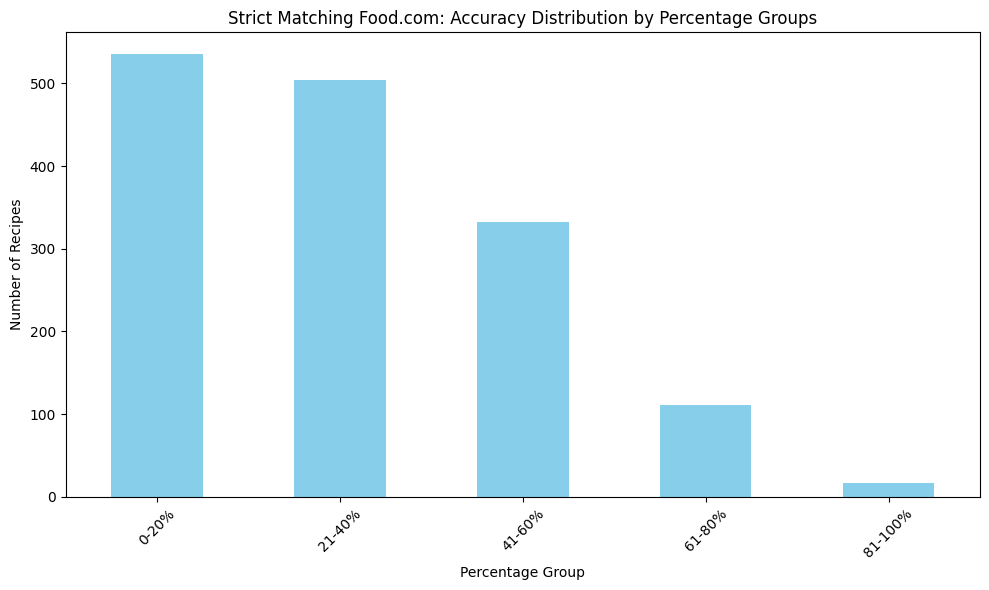

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\instructions_extracted_food.com_strict.csv")

# Define percentage groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

# Create a new column for percentage groups
df['percentage_group'] = pd.cut(df['matched_ingredients_percentage'], bins=bins, labels=labels, include_lowest=True)

# Plot the distribution of percentage groups
plt.figure(figsize=(10, 6))
df['percentage_group'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Strict Matching Food.com: Accuracy Distribution by Percentage Groups')
plt.xlabel('Percentage Group')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\ri_food.com_percentage_distribution_strict.png")
plt.show()


## Loose Matching Plot

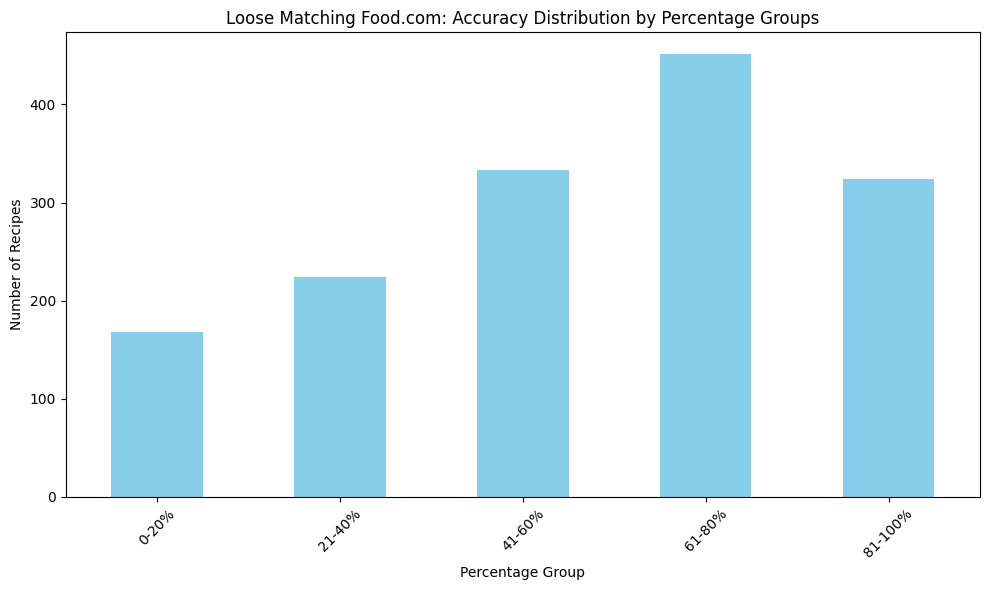

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\instructions_extracted_food.com_checked_loose.csv")

# Define percentage groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

# Create a new column for percentage groups
df['percentage_group'] = pd.cut(df['matched_ingredients_percentage'], bins=bins, labels=labels, include_lowest=True)

# Plot the distribution of percentage groups
plt.figure(figsize=(10, 6))
df['percentage_group'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Loose Matching Food.com: Accuracy Distribution by Percentage Groups')
plt.xlabel('Percentage Group')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\ri_food.com_percentage_distribution_loose.png")
plt.show()


# Checked Loose Matching Plot

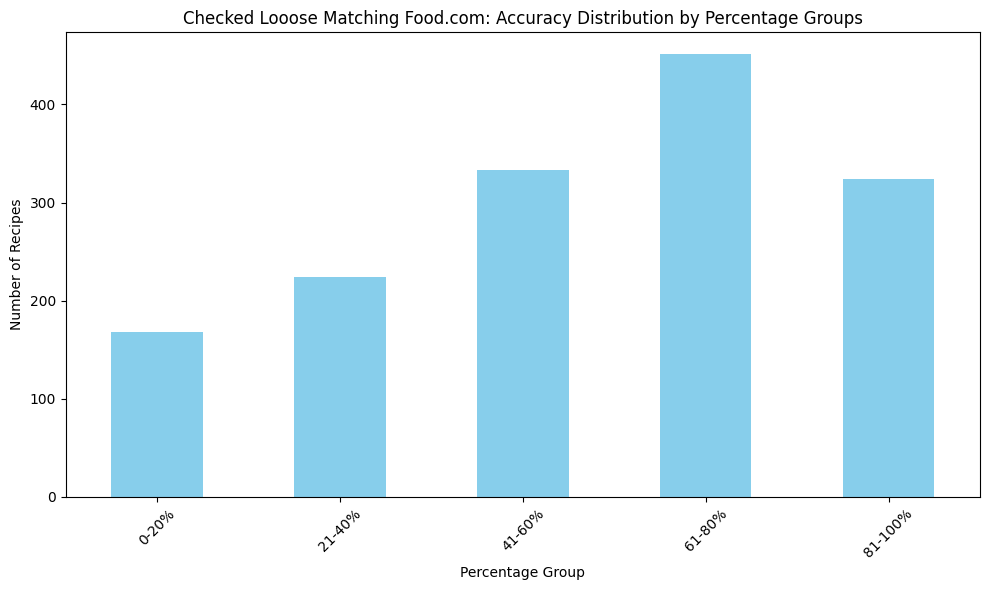

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\instructions_extracted_food.com_checked_loose.csv")

# Define percentage groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

# Create a new column for percentage groups
df['percentage_group'] = pd.cut(df['matched_ingredients_percentage'], bins=bins, labels=labels, include_lowest=True)

# Plot the distribution of percentage groups
plt.figure(figsize=(10, 6))
df['percentage_group'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Checked Looose Matching Food.com: Accuracy Distribution by Percentage Groups')
plt.xlabel('Percentage Group')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\ri_food.com_distribution_checked_loose.png")
plt.show()
